# This script processes SYCL and CUDA results 

1. Go to SYCL-CUDA directory and compile all versions with:
```
make
```
2. Run the benchmarking script
```
cd scripts
python3 run_sycl_cuda.py
```
3. The output that we will process is sycl_cuda_coffee.txt (renamed from sycl_cuda_output.out)



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys
from statistics import mean

def tokenize(filename):
    experiment ={}

    with open(filename) as f:
        for line in f:
            tokens = line.split()
            if "Running:" in tokens:
                version=tokens[1].split("/")[2]
                input=tokens[2].split("/")[3][:-4]
                match input:
                    case "INAER_2011_Alcoy_Core":
                       cloud="Alcoy"
                    case "BABCOCK_2017_Arzua_3B":
                        cloud="Arzua"
                    case "V21_group1_densified_point_cloud":
                        cloud="BrionF"
                    case "V19_group1_densified_point_cloud":
                        cloud="BrionU"
                maxNum=int(tokens[3])
                if version not in experiment:
                    experiment[version]={}
                if cloud not in experiment[version]:
                    experiment[version][cloud]={}
                experiment[version][cloud][maxNum]=[]
            if 'Construction' in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[5]))
            if "Stage1" in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[5]))
            if "Stage2" in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[5]))
            if "Total" in tokens and "KERNEL" in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[5]))
            if 'TIME' in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[6]))

    return experiment

res=tokenize("sycl_cuda_coffee.txt")
#print(res)



{'owm-sycl-cpu': {'Alcoy': {16: [438.448, 201.869, 4.35985, 206.229, 644.677], 32: [405.436, 193.493, 4.43799, 197.931, 603.367], 64: [389.042, 186.569, 4.37391, 190.942, 579.984], 128: [379.818, 229.027, 4.26183, 233.289, 613.107], 256: [378.175, 243.583, 4.59327, 248.176, 626.351], 512: [372.763, 255.611, 4.13041, 259.741, 632.504], 1024: [373.006, 462.723, 4.23422, 466.958, 839.964]}, 'Arzua': {16: [961.601, 202.786, 2.008, 204.794, 1166.39], 32: [865.685, 201.04, 1.95873, 202.999, 1068.68], 64: [834.865, 201.029, 2.10277, 203.131, 1038.0], 128: [815.024, 195.857, 1.90205, 197.759, 1012.78], 256: [805.311, 279.384, 2.01872, 281.402, 1086.71], 512: [802.926, 299.876, 1.9733, 301.849, 1104.78], 1024: [802.446, 330.376, 1.81947, 332.195, 1134.64]}, 'BrionF': {16: [1120.38, 123.114, 0.752567, 123.867, 1244.24], 32: [1023.23, 126.998, 0.706299, 127.704, 1150.94], 64: [989.133, 116.965, 0.800051, 117.765, 1106.9], 128: [971.439, 110.873, 0.708257, 111.581, 1083.02], 256: [955.93, 207.368,

In [8]:
allmaxnums=[i for i in res['owm-sycl-cpu']['Alcoy']]
print(allmaxnums)

for ver in res:
    print("Version {}".format(ver))
    for cloud in res[ver]:
        treetimes=np.array([res[ver][cloud][i][0] for i in res[ver][cloud]])
        bestMNtree=np.argmin(treetimes)
        bestTreeTime=treetimes[bestMNtree]
        owmtimes=np.array([res[ver][cloud][i][3] for i in res[ver][cloud]])
        bestMNowm=np.argmin(owmtimes)
        bestowmTime=owmtimes[bestMNowm]
        totaltimes=np.array([res[ver][cloud][i][4] for i in res[ver][cloud]])
        bestMNtotal=np.argmin(totaltimes)
        besttotalTime=totaltimes[bestMNtotal]
        print("Cloud {} has TreeC. time={:.2f} (maxN={}), OWM time={:.2f} (maxN={}) and Total Time={:.2f} (maxN={}) in ms.".format(cloud,\
                                 bestTreeTime,allmaxnums[bestMNtree],bestowmTime,allmaxnums[bestMNowm],besttotalTime,allmaxnums[bestMNtotal]))



[16, 32, 64, 128, 256, 512, 1024]
Version owm-sycl-cpu
Cloud Alcoy has TreeC. time=372.76 (maxN=512), OWM time=190.94 (maxN=64) and Total Time=579.98 (maxN=64) in ms.
Cloud Arzua has TreeC. time=802.45 (maxN=1024), OWM time=197.76 (maxN=128) and Total Time=1012.78 (maxN=128) in ms.
Cloud BrionF has TreeC. time=955.03 (maxN=1024), OWM time=111.58 (maxN=128) and Total Time=1083.02 (maxN=128) in ms.
Cloud BrionU has TreeC. time=1089.65 (maxN=1024), OWM time=126.48 (maxN=128) and Total Time=1232.06 (maxN=128) in ms.
Version owm-sycl-cpu-nomemo
Cloud Alcoy has TreeC. time=375.41 (maxN=1024), OWM time=226.93 (maxN=64) and Total Time=621.16 (maxN=64) in ms.
Cloud Arzua has TreeC. time=799.60 (maxN=1024), OWM time=267.52 (maxN=128) and Total Time=1085.12 (maxN=128) in ms.
Cloud BrionF has TreeC. time=961.44 (maxN=256), OWM time=188.38 (maxN=128) and Total Time=1167.89 (maxN=128) in ms.
Cloud BrionU has TreeC. time=1084.88 (maxN=512), OWM time=229.46 (maxN=128) and Total Time=1318.17 (maxN=512)

In [17]:
#memo vs no memo comparison
allmaxnums=[i for i in res['owm-sycl-cpu']['Alcoy']]
for ver in res:
    if ver=="owm-cuda" or "nomemo" in ver.split("-"):
        continue
    print("Version {}".format(ver))
    for cloud in res[ver]:
        owmtimes=np.array([res[ver][cloud][i][3] for i in res[ver][cloud]])
        bestMNowm=np.argmin(owmtimes)
        bestowmTime=owmtimes[bestMNowm]
        bestMN=allmaxnums[bestMNowm]
        print("Cloud {} has OWM time={:.2f} ms (maxN={}) that is {:.2f}x faster than without memo (time={:.2f} ms)".format(cloud,bestowmTime,bestMN\
                                                       ,res[ver+"-nomemo"][cloud][bestMN][3]/bestowmTime, res[ver+"-nomemo"][cloud][bestMN][3] ))


Version owm-sycl-cpu
Cloud Alcoy has OWM time=190.94 ms (maxN=64) that is 1.19x faster than without memo (time=226.93 ms)
Cloud Arzua has OWM time=197.76 ms (maxN=128) that is 1.35x faster than without memo (time=267.52 ms)
Cloud BrionF has OWM time=111.58 ms (maxN=128) that is 1.69x faster than without memo (time=188.38 ms)
Cloud BrionU has OWM time=126.48 ms (maxN=128) that is 1.81x faster than without memo (time=229.46 ms)
Version owm-sycl-igpu
Cloud Alcoy has OWM time=1179.31 ms (maxN=16) that is 1.21x faster than without memo (time=1427.45 ms)
Cloud Arzua has OWM time=1132.18 ms (maxN=16) that is 2.15x faster than without memo (time=2435.94 ms)
Cloud BrionF has OWM time=647.52 ms (maxN=16) that is 3.53x faster than without memo (time=2284.69 ms)
Cloud BrionU has OWM time=703.16 ms (maxN=16) that is 3.74x faster than without memo (time=2627.53 ms)
Version owm-sycl-dgpu
Cloud Alcoy has OWM time=211.50 ms (maxN=16) that is 1.36x faster than without memo (time=287.26 ms)
Cloud Arzua h

# Execution time of memo versions for all maxNumbers

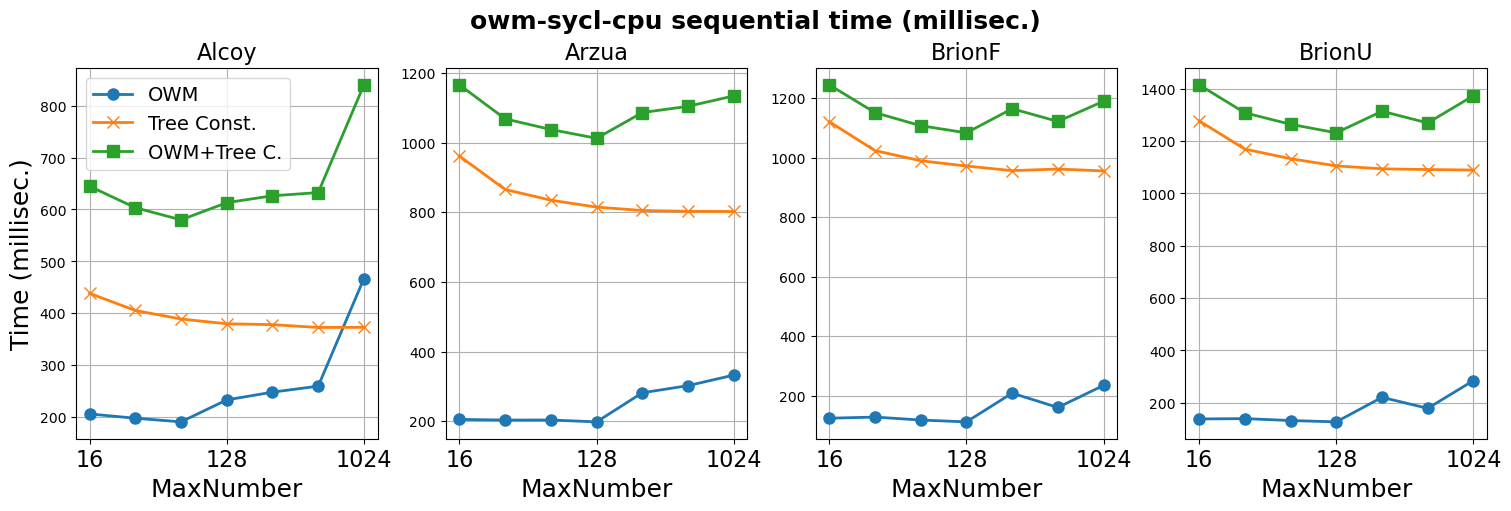

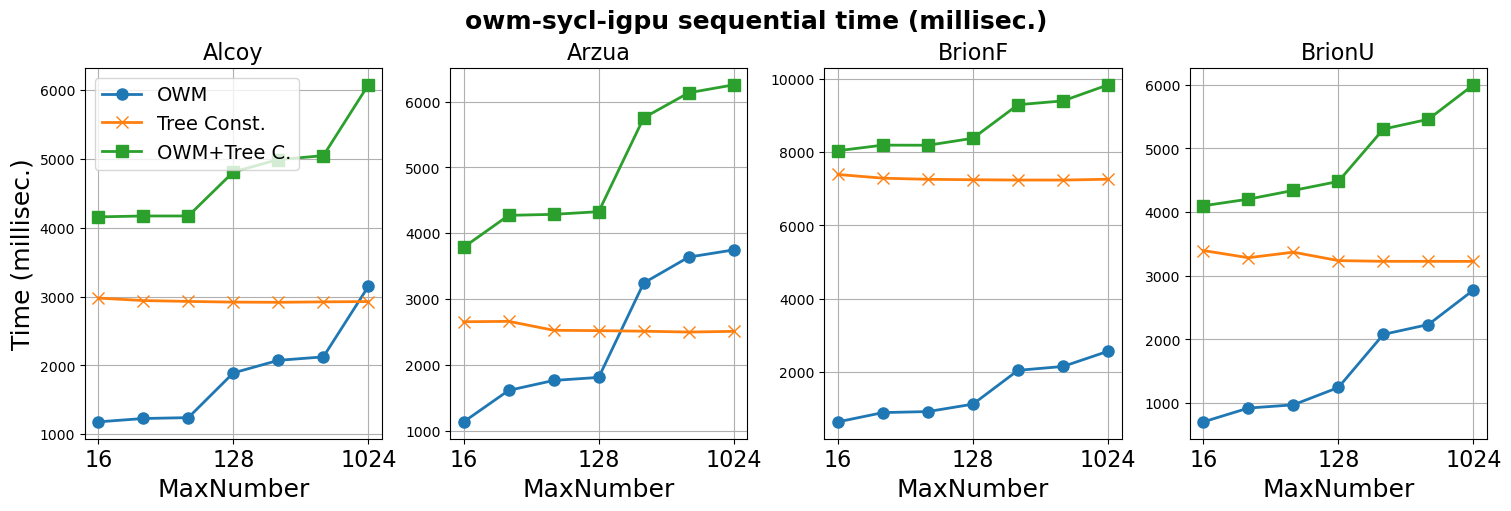

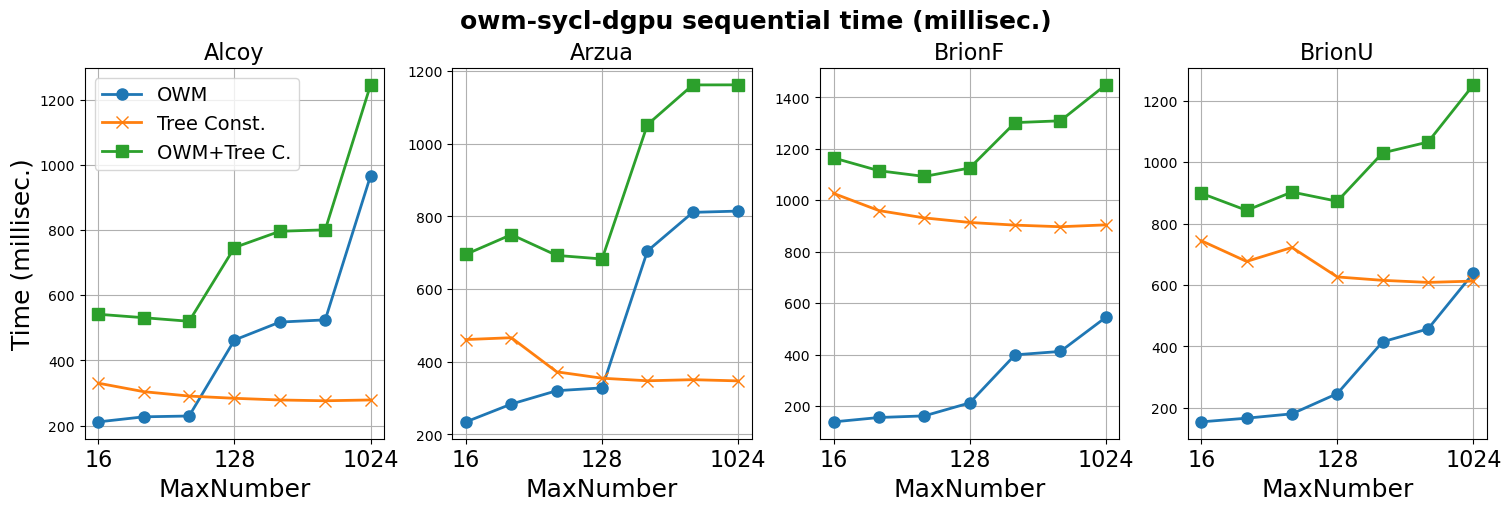

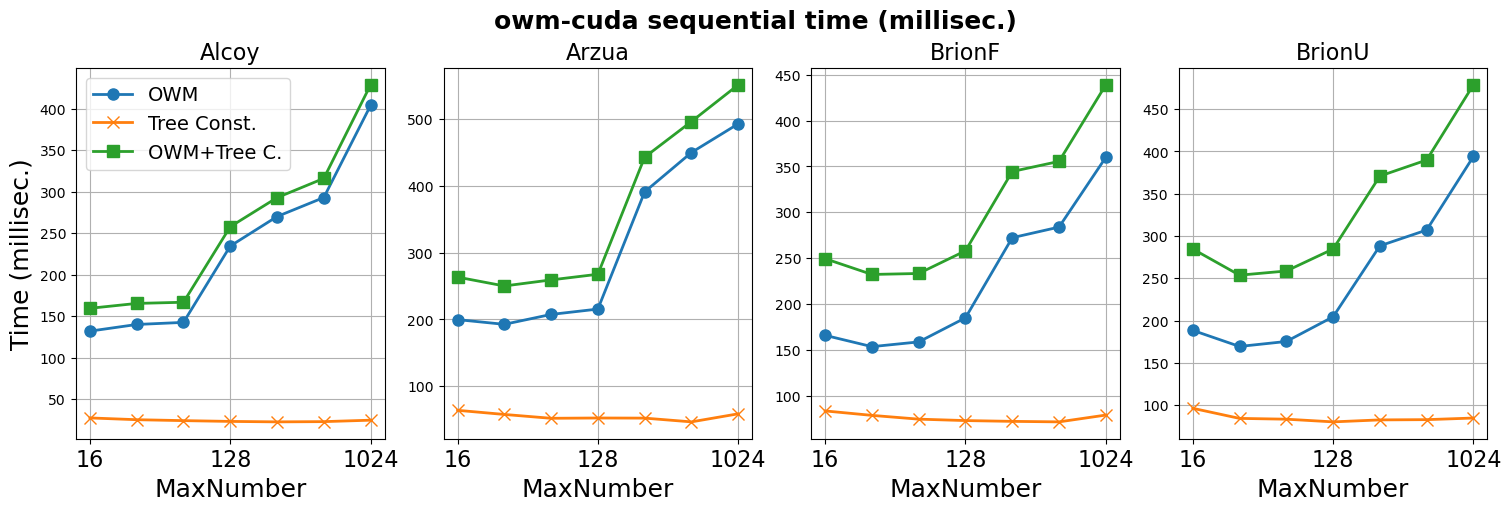

In [22]:
def plot_alltimes(results,version):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    #fig = plt.figure()
    labels=['OWM','Tree Const.','OWM+Tree C.']
    x=list(results[version]['Alcoy'].keys())
    xticks=range(1,len(x)+1)
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4),['Alcoy','Arzua','BrionF','BrionU']):
        axs[i].plot(np.array(xticks), np.array([results[version][name][i][3] for i in x]), marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(xticks), np.array([results[version][name][i][0] for i in x]), marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(xticks), np.array([results[version][name][i][4] for i in x]), marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('MaxNumber', fontsize=xlabelfs)
        axs[i].set_xticks(ticks=xticks[::3], labels=x[::3],fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()

    fig.suptitle(version + ' sequential time (millisec.)',  fontweight='bold', fontsize=18)
    axs[0].set_ylabel('Time (millisec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    #axs[i].show()

plot_alltimes(res,"owm-sycl-cpu")
plot_alltimes(res,"owm-sycl-igpu")
plot_alltimes(res,"owm-sycl-dgpu")
plot_alltimes(res,"owm-cuda")